# Basic EDA of Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
# For NLP vectorizing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# # imports in helpers.py
# import unicodedata
# import string
# import re

# from nltk.util import ngrams
# from nltk.tokenize import sent_tokenize, word_tokenize
# from nltk.corpus import stopwords
# from nltk.stem.snowball import SnowballStemmer

# import nltk
# from nltk.corpus import wordnet
# from nltk.stem import WordNetLemmatizer

# np.set_printoptions(linewidth=100) 

# pt = string.punctuation
# sw = stopwords.words('english')
# stemmer = SnowballStemmer('english')

from wordcloud import WordCloud, STOPWORDS
from src.helpers import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from sklearn.model_selection import train_test_split
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, log_loss, accuracy_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

import statsmodels.api as sm
from scipy.stats import norm, t
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.inspection import plot_partial_dependence

In [4]:
# import kaggle data
kaggle_real = pd.read_csv('data/kaggle_news/True.csv')
kaggle_fake = pd.read_csv('data/kaggle_news/Fake.csv')

In [5]:
# label real news as 1 and fake news as 0

kaggle_real['label'] = 1
kaggle_fake['label'] = 0

In [6]:
# extra labeled data from outside source
extra = pd.read_csv('data/extra_news.csv')

In [7]:
kaggle_fake.shape

(23481, 5)

In [8]:
kaggle_real.shape

(21417, 5)

In [9]:
# merging real and fake data into one dataset
news = pd.concat([kaggle_fake, kaggle_real]).reset_index(drop = True)

In [10]:
news.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [11]:
news['char_count'] = news.text.apply(lambda x: len(x))

In [12]:
news['word_count'] = news.text.apply(lambda x: len(x.split()))

In [13]:
news.char_count.mean()

2469.1096930820972

In [14]:
# average length of real articles
news[news.label == 1]['word_count'].mean()

385.6400989867862

In [15]:
# average length of fake articles
news[news.label == 0]['word_count'].mean()

423.1979046888974

In [16]:
# visualize class balance

balance = news.label.value_counts()
balance

0    23481
1    21417
Name: label, dtype: int64

<BarContainer object of 2 artists>

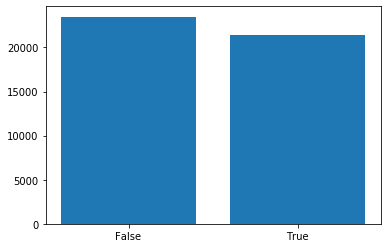

In [17]:
# notice similar class balance

plt.bar(balance.index, balance.values, tick_label = ['False', 'True'])

In [18]:
subjects_real = news[news['label'] == 0]['subject'].value_counts()
subjects_fake = news[news['label'] == 0]['subject'].value_counts()
subjects_real

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

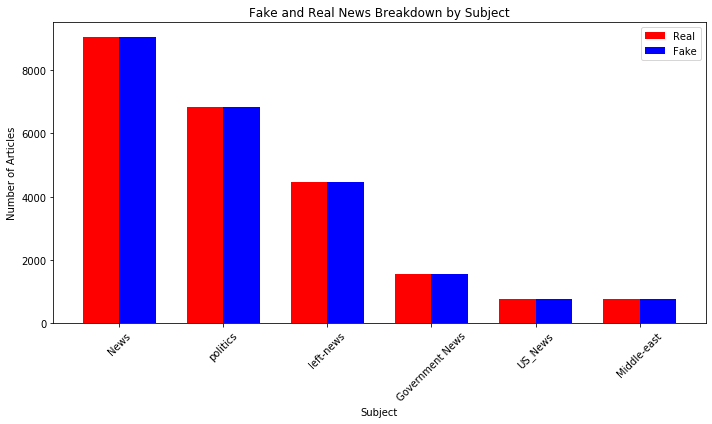

In [19]:
fig, ax = plt.subplots(1, figsize = (10, 6))

labels = subjects_real.index
x = np.arange(len(labels))
width = 0.35

ax.bar(x - width/2, subjects_real.values, width, label = 'Real', color = 'r')
ax.bar(x + width/2, subjects_fake.values, width, label = 'Fake', color = 'b')

ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.title('Fake and Real News Breakdown by Subject')
plt.ylabel('Number of Articles')
plt.xlabel('Subject')
plt.rc('xtick', labelsize=13) 
plt.xticks(rotation =45)
plt.rc('ytick', labelsize=17) 
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize = 17)
plt.legend()
plt.tight_layout()
# plt.savefig('images/subject_breakdown.jpg')

# Creating NLP Vectors

In [18]:
# splitting the data

#split data into target and features, stratify to maintain class balance
y = news['label']
X = news['text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [16]:
y_train.shape

(35918,)

In [17]:
X_train.shape

(35918,)

In [18]:
# # Validation Split  (Using cross validation instead)

# X_valtrain, X_valtest, y_valtrain, y_valtest = train_test_split(X_train, y_train, test_size=0.2, random_state=1, stratify=y_train)


In [19]:
# Demonstrating Preprocessor

doc = 'Hello!!! I am a TEST arTicle       *** ^^ that demonstrates how the text preprocessor works. It is a lovely, sunny day outside with green trees and many colored birds.'

preprocessor(doc)

'hello i be a test article that demonstrate how the text preprocessor work it be a lovely sunny day outside with green tree and many color bird'

In [20]:
# count vectorizer with bigrams and trigrams, top 100,000 most frequent tokens
cv = CountVectorizer(preprocessor=preprocessor, stop_words=stopwords_list(), ngram_range=(1, 3), max_features=100000)
cv_train_model = cv.fit(X_train)

In [21]:
# transform data to get counts of words
cv_X_train = cv_train_model.transform(X_train)
features = cv.get_feature_names()
word_count_df = pd.DataFrame(cv_X_train.toarray(), columns=features)

In [22]:
word_count_df.shape

(35918, 100000)

In [23]:
# alternate method
cv_X_train_df = cv_X_train.todense()
columns = sorted(cv_train_model.vocabulary_, key=lambda k: cv_train_model.vocabulary_[k])
cv_X_train_df = pd.DataFrame(cv_X_train_df, columns=columns);

In [24]:
cv_X_train_df.shape

(35918, 100000)

In [25]:
# top 20 highest count of words for real news

np.sum(cv_X_train_df[np.array(y_train)==1], axis=0).sort_values(ascending=False)[:10]

say           90735
trump         44092
state         29938
would         25190
reuters       23148
president     22907
year          17829
republican    17656
government    15974
house         13781
dtype: int64

In [26]:
# Term frequency-Inverse document frequency vectorizer with bigrams and trigrams, top 100,000 highest weighted tokens
tfidf = TfidfVectorizer(preprocessor=preprocessor, stop_words=stopwords_list(), ngram_range=(1, 3), max_features=100000)
tfidf_train_model = tfidf.fit(X_train)


In [27]:
# # save the training model
# with open('tfidf_train_model.pkl', 'wb') as f:
#     pickle.dump(tfidf_train_model, f)

In [28]:
# vocabulary
sorted(tfidf_train_model.vocabulary_.items(), key=lambda x: x[1], reverse=True)[:20]


[('zurich reuters', 99999),
 ('zurich', 99998),
 ('zuma say', 99997),
 ('zuma guptas deny', 99996),
 ('zuma guptas', 99995),
 ('zuma former', 99994),
 ('zuma', 99993),
 ('zulia state', 99992),
 ('zulia', 99991),
 ('zuckerberg say', 99990),
 ('zuckerberg', 99989),
 ('zucker', 99988),
 ('zor province', 99987),
 ('zor city', 99986),
 ('zor', 99985),
 ('zoomph', 99984),
 ('zoo', 99983),
 ('zones', 99982),
 ('zone would', 99981),
 ('zone syria', 99980)]

In [29]:
# transform the data using the tfidf vectorizer
tfidf_X_train = tfidf_train_model.transform(X_train)

In [30]:
# tfidf dataframe
tfidf_X_train_df = tfidf_X_train.todense()
columns = sorted(tfidf_train_model.vocabulary_, key=lambda k: tfidf_train_model.vocabulary_[k])
tfidf_X_train_df = pd.DataFrame(tfidf_X_train_df, columns=columns);

In [31]:
# top 20 scoring words for real news

np.sum(tfidf_X_train_df[np.array(y_train)==1], axis=0).sort_values(ascending=False)[:10]


say           841.355465
trump         541.067084
state         381.744631
reuters       380.831829
president     312.431183
would         305.316186
republican    278.449815
government    266.650643
house         248.166914
year          235.860570
dtype: float64

In [32]:
# top 20 scoring words for fake news

np.sum(tfidf_X_train_df[np.array(y_train)==0], axis=0).sort_values(ascending=False)[:10]


trump        868.697439
say          370.175866
clinton      328.577763
people       302.729280
go           295.208577
obama        288.840402
president    286.673302
get          276.370834
hillary      270.167593
one          265.191800
dtype: float64

In [33]:
# # For final model

# tfidf = TfidfVectorizer(preprocessor=preprocessor, stop_words=stopwords_list())
# tfidf_model = tfidf.fit(X)
# tfidf_X = tfidf_train_model.transform(X)

# X_df = pd.DataFrame(vectorized_X.toarray())
# X_df.shape

In [34]:
# # reload training model

# with open('cv_train_model.pkl', 'rb') as f:
#     cv_model = pickle.load(f)

# Testing Classification Models

In [35]:
# Logistic Regression 5 folds

log_cross = cross_validate(LogisticRegression(max_iter = 400, random_state = 42), tfidf_X_train, y_train, scoring = ['accuracy', 'precision', 'recall'], n_jobs = -1)
log_cross.update((x, y.mean()) for x, y in log_cross.items())
log_cross

{'fit_time': 2.194135808944702,
 'score_time': 0.014825677871704102,
 'test_accuracy': 0.9872208400371205,
 'test_precision': 0.9848232932908239,
 'test_recall': 0.9884432558929458}

In [36]:
# Random Forest Classifier using trial and error parameters, rather than waiting for grid search

rfc = RandomForestClassifier(criterion='gini', max_depth = 200, n_estimators = 50, max_features = 'auto', oob_score = True, random_state=42).fit(tfidf_X_train, y_train)
print(rfc.oob_score_)

0.9880839690405925


In [37]:
feat_scores = pd.DataFrame({'Top 10 Important Features':rfc.feature_importances_}, index = columns)
#feat_scores.sort_values(by = 'Fraction of Samples Affected').plot(kind='barh');

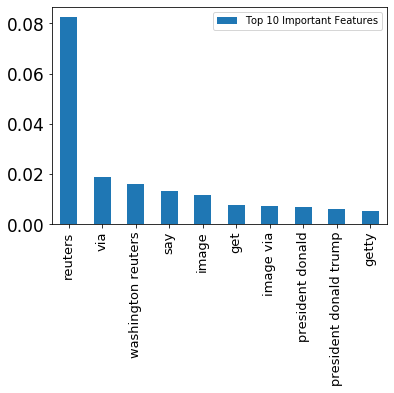

In [38]:
feat_scores.sort_values(by = 'Top 10 Important Features', ascending=False)[:10].plot(kind='bar');

### 'Reuters' giving off too much signal! It is a news service so lets find the distribution comparing its appearance in real and fake news.

In [39]:
cv_X_train_df.sum(axis=0).loc['reuters']

23478

In [40]:
reuters_fake_count = np.sum(cv_X_train_df[np.array(y_train)==0], axis=0).loc['reuters']
reuters_fake_count

330

In [41]:
reuters_real_count = np.sum(cv_X_train_df[np.array(y_train)==1], axis=0).loc['reuters']
reuters_real_count

23148

In [42]:
reuters_real_count / (reuters_real_count + reuters_fake_count)

0.9859442882698697

In [43]:
reuters_fake_count / (reuters_real_count + reuters_fake_count)

0.014055711730130335

99% of the real data has 'reuters' in it and 1% of the fake data has 'reuters' in it

In [44]:
image_fake_count = np.sum(cv_X_train_df[np.array(y_train)==0], axis=0).loc['image']
image_fake_count

11090

In [45]:
image_real_count = np.sum(cv_X_train_df[np.array(y_train)==1], axis=0).loc['image']
image_real_count

467

In [46]:
say_real_count = np.sum(cv_X_train_df[np.array(y_train)==1], axis=0).loc['say']
say_real_count

90735

In [47]:
say_fake_count = np.sum(cv_X_train_df[np.array(y_train)==0], axis=0).loc['say']
say_fake_count

39135

In [48]:
# random forest classifier 5 folds

rfc_cross = cross_validate(RandomForestClassifier(criterion='gini', max_depth = 200, n_estimators = 50, max_features = 'auto', oob_score = True, random_state=42),
                                                    tfidf_X_train, y_train, scoring = ['accuracy', 'precision', 'recall'],cv=5, n_jobs=-1)
rfc_cross.update((x, y.mean()) for x, y in rfc_cross.items())
rfc_cross

{'fit_time': 27.829764795303344,
 'score_time': 0.7977253437042237,
 'test_accuracy': 0.9915362599828164,
 'test_precision': 0.9899851322645356,
 'test_recall': 0.9922954982504752}

In [49]:
# gradient boosted Classifier 5 folds

gradient_cross = cross_validate(GradientBoostingClassifier(random_state = 42), tfidf_X_train, y_train, scoring = ['accuracy', 'precision', 'recall'],cv=5, n_jobs=-1)
gradient_cross.update((x, y.mean()) for x, y in gradient_cross.items())
gradient_cross

{'fit_time': 257.63558464050294,
 'score_time': 0.07884726524353028,
 'test_accuracy': 0.9954340155098945,
 'test_precision': 0.9937220930059683,
 'test_recall': 0.9967314436318435}

In [50]:
# Naive Bayes Classifier 5 Folds

nb_cross = cross_validate(MultinomialNB(alpha=0.1), tfidf_X_train, y_train, scoring = ['accuracy', 'precision', 'recall'],cv=5, n_jobs=-1)
nb_cross.update((x, y.mean()) for x, y in nb_cross.items())
nb_cross

{'fit_time': 0.11124873161315918,
 'score_time': 0.019825029373168945,
 'test_accuracy': 0.9622194757666813,
 'test_precision': 0.961778480234908,
 'test_recall': 0.9589097498641926}

## Removing Certain Features and Retraining the vectors

In [19]:
# Term frequency-Inverse document frequency vectorizer with bigrams and trigrams, top 100,000 highest weighted tokens
tfidf2 = TfidfVectorizer(preprocessor=preprocessor, stop_words=stopwords_list() + ['reuters'], ngram_range=(1, 3), max_features=10000)
tfidf_X_train_2 = tfidf2.fit_transform(X_train)


In [55]:
# # save the training model
# with open('../tfidf_train_model.pkl', 'wb') as f:
#     pickle.dump(tfidf_train_model, f)

In [19]:
# # reload training model

# with open('../tfidf_train_model.pkl', 'rb') as f:
#     tfidf_train_model2 = pickle.load(f)

In [29]:
# tfidf_X_train_2 = tfidf_train_model2.transform(X_train)

In [ ]:
# from scipy import sparse

# columns = sorted(tfidf2.vocabulary_, key=lambda k: tfidf2.vocabulary_[k])
# x_new = sparse.lil_matrix(sparse.csr_matrix(tfidf_X_train_2)[:,columns])

In [20]:
# tfidf dataframe
tfidf_X_train_2_df = tfidf_X_train_2.todense()
columns = sorted(tfidf2.vocabulary_, key=lambda k: tfidf2.vocabulary_[k])
tfidf_X_train_2_df = pd.DataFrame(tfidf_X_train_2_df, columns=columns);

In [21]:
# Random Forest Classifier using trial and error parameters, rather than waiting for grid search

rfc = RandomForestClassifier(criterion='gini', max_depth = 200, n_estimators = 50, max_features = 'auto', oob_score = True, random_state=42).fit(tfidf_X_train_2, y_train)
print(rfc.oob_score_)

0.9769474915084359


In [22]:
columns = sorted(tfidf2.vocabulary_, key=lambda k: tfidf2.vocabulary_[k])
feat_scores = pd.DataFrame({'Top 10 Important Features':rfc.feature_importances_}, index = columns)
#feat_scores.sort_values(by = 'Fraction of Samples Affected').plot(kind='barh');

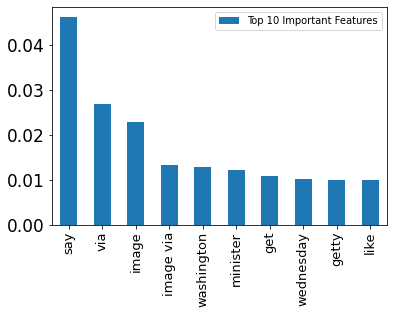

In [23]:
feat_scores.sort_values(by = 'Top 10 Important Features', ascending=False)[:10].plot(kind='bar');

In [ ]:
# # Partial Dependence Plot (reduce features or else breaks kernel)
# features = ['via','say','image']
# plot_partial_dependence(rfc, tfidf_X_train_2_df, features, n_jobs=-1)
# fig = plt.gcf()

In [120]:
# Testing on holdout set from train-test split

X_test_tfidf = tfidf2.transform(X_test)
y_hat = rfc.predict(X_test_tfidf)
accuracy_score(y_test, y_hat)

0.9846325167037862

#### I suspect an overfitting to this dataset, lets test with the extra data

In [24]:
# extra dataset outside news articles to test on
extra.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [26]:
extra['label'] = (extra['label'] == 'REAL')*1

In [119]:
extra.shape

(6335, 4)

In [27]:
extra.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


In [28]:
# splitting the data

#split data into target and features, stratify to maintain class balance
y_extra = extra['label']
X_extra = extra['text']

In [33]:
# baseline of extra data
y_extra.sum() / len(y_extra)

0.5005524861878453

In [29]:
X_extra_tfidf = tfidf2.transform(X_extra)

In [30]:
rfc_y_hat = rfc.predict(X_extra_tfidf)

In [31]:
# the data shows some improvement but obviously very overfit to the particular kaggle dataset

accuracy_score(y_extra, rfc_y_hat)

0.5957379636937647

#### Yes, very obvious overfitting to this data, only about 10% increase in signal dectection from baseline

# Time to bring in More Data!

In [21]:
# original kaggle dataset

kaggle = news[['text', 'label']]

In [22]:
kaggle.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [23]:
kaggle.label.mean()

0.47701456635039424

In [45]:
# data verified by politifact

politifact = pd.read_csv('data/politifact_data.csv')

In [46]:
politifact.head()

,Unnamed: 0,text,label
0,0,"If you pass the so-called Dream Act, it will b...",0
1,1,12 more hurricanes headed towards U.S.,0
2,2,NFL attendance and ratings are WAY DOWN. Borin...,0
3,5,Roy Moore fought for pay increases for politic...,0
4,6,The Graham-Cassidy health care bill does inclu...,0


In [47]:
politifact = politifact[['text', 'label']]

In [48]:
politifact.shape

(8325, 2)

In [49]:
# correct format
politifact.head()

,text,label
0,"If you pass the so-called Dream Act, it will b...",0
1,12 more hurricanes headed towards U.S.,0
2,NFL attendance and ratings are WAY DOWN. Borin...,0
3,Roy Moore fought for pay increases for politic...,0
4,The Graham-Cassidy health care bill does inclu...,0


In [50]:
# 42% of the data is fake news

politifact.label.mean()

0.43003003003003004

In [52]:
# data from the onion (only using actual onion data for fake news)
onion = pd.read_csv('data/OnionOrNot.csv')

In [53]:
# 1 is an onion article so must be changed to 0 to match with other datasets for fake
onion = onion[onion.label == 1]
onion.label = 0

In [54]:
# correct format
onion.head()

,text,label
0,Entire Facebook Staff Laughs As Man Tightens P...,0
2,Bold Move: Hulu Has Announced That They’re Gon...,0
3,Despondent Jeff Bezos Realizes He’ll Have To W...,0
4,"For men looking for great single women, online...",0
5,Kim Jong-Un Wonders If Nuclear Threats Distrac...,0


In [55]:
onion.shape

(9000, 2)

In [57]:
# load NYT data

NYT = pd.read_csv('data/NYT.csv')

In [58]:
# only taking NYT articles

NYT = NYT[NYT.publication == 'New York Times']

In [59]:
# only taking content and setting label to true

NYT = NYT[['content']]
NYT['label'] = 1

In [60]:
# rename content to text
NYT.rename(columns={"content": "text"}, inplace = True)

In [61]:
# correct format
NYT.head()

,text,label
0,WASHINGTON — Congressional Republicans have...,1
1,"After the bullet shells get counted, the blood...",1
2,"When Walt Disney’s “Bambi” opened in 1942, cri...",1
3,"Death may be the great equalizer, but it isn’t...",1
4,"SEOUL, South Korea — North Korea’s leader, ...",1


In [62]:
NYT.shape

(7803, 2)

In [63]:
# concat all datasets

df_all = pd.concat([kaggle, politifact, onion, NYT]).reset_index(drop = True)

In [64]:
df_all.to_csv('data/all_data.csv')

In [65]:
df_all.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [66]:
df_all.shape

(70026, 2)

In [67]:
# new baseline

1 - df_all.label.mean()

0.5316025476251678

# Modeling on new dataframe

In [68]:
df_all = pd.read_csv('data/all_data.csv').reset_index(drop = True)

In [69]:
df_all = df_all[['text', 'label']]

In [70]:
df_all.isna().sum()

text     0
label    0
dtype: int64

In [71]:
# splitting the data

#split data into target and features, stratify to maintain class balance
y = df_all['label']
X = df_all['text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Term frequency-Inverse document frequency vectorizer with bigrams and trigrams, top 100,000 highest weighted tokens
tfidf = TfidfVectorizer(preprocessor=preprocessor, stop_words=stopwords_list() + ['reuters'], ngram_range=(1, 3), max_features=20000)
tfidf_train_model = tfidf.fit(X_train)


In [ ]:
# transform the data using the tfidf vectorizer
tfidf_X_train = tfidf_train_model.transform(X_train)

In [ ]:
# tfidf dataframe
tfidf_X_train_df = tfidf_X_train.todense()
columns = sorted(tfidf_train_model.vocabulary_, key=lambda k: tfidf_train_model.vocabulary_[k])
tfidf_X_train_df = pd.DataFrame(tfidf_X_train_df, columns=columns);

In [ ]:
# top 20 scoring words for real news

np.sum(tfidf_X_train_df[np.array(y_train)==1], axis=0).sort_values(ascending=False)[:10]


In [ ]:
# top 20 scoring words for fake news

np.sum(tfidf_X_train_df[np.array(y_train)==0], axis=0).sort_values(ascending=False)[:10]


In [ ]:
# Logistic Regression 5 folds

log_cross = cross_validate(LogisticRegression(max_iter = 400, random_state = 42), tfidf_X_train, y_train, scoring = ['accuracy', 'precision', 'recall'], n_jobs = -1)
log_cross.update((x, y.mean()) for x, y in log_cross.items())
log_cross

In [ ]:
# random forest classifier 5 folds

rfc_cross = cross_validate(RandomForestClassifier(criterion='gini', max_depth = 200, n_estimators = 50, max_features = 'auto', oob_score = True, random_state=42),
                                                    tfidf_X_train, y_train, scoring = ['accuracy', 'precision', 'recall'],cv=5, n_jobs=-1)
rfc_cross.update((x, y.mean()) for x, y in rfc_cross.items())
rfc_cross

In [ ]:
# gradient boosted Classifier 5 folds

gradient_cross = cross_validate(GradientBoostingClassifier(random_state = 42), tfidf_X_train, y_train, scoring = ['accuracy', 'precision', 'recall'],cv=5, n_jobs=-1)
gradient_cross.update((x, y.mean()) for x, y in gradient_cross.items())
gradient_cross

In [ ]:
# Naive Bayes Classifier 5 Folds

nb_cross = cross_validate(MultinomialNB(alpha=0.1), tfidf_X_train, y_train, scoring = ['accuracy', 'precision', 'recall'],cv=5, n_jobs=-1)
nb_cross.update((x, y.mean()) for x, y in nb_cross.items())
nb_cross

In [ ]:
# Random Forest Classifier using trial and error parameters, rather than waiting for grid search

rfc = RandomForestClassifier(criterion='gini', max_depth = 200, n_estimators = 50, max_features = 'auto', oob_score = True, random_state=42).fit(tfidf_X_train, y_train)
print(rfc.oob_score_)

In [ ]:
feat_scores = pd.DataFrame({'Top 10 Important Features':rfc.feature_importances_}, index = columns)
#feat_scores.sort_values(by = 'Fraction of Samples Affected').plot(kind='barh');

In [ ]:
feat_scores.sort_values(by = 'Top 10 Important Features', ascending=False)[:10].plot(kind='bar');

In [ ]:
# Testing on holdout set from train-test split

X_test_tfidf = tfidf.transform(X_test)
y_hat = rfc.predict(X_test_tfidf)
accuracy_score(y_test, y_hat)